# 🛍️ **Customer Churn Prediction in E-commerce with Google Cloud**


This project aims to **predict customer churn behavior** in an e-commerce environment, using the publicly available **[TheLook eCommerce dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce)** hosted on **Google BigQuery**.


---

## 📌 Project Overview

The ultimate goal is to support marketing and retention strategies by identifying which customers are most likely to stop purchasing, allowing the business to take proactive actions before they churn.

Customer churn is a critical problem for online retailers, as acquiring new customers is often more expensive than retaining existing ones. Through data exploration, survival analysis, and machine learning, this project will seek to uncover patterns in customer behavior and build predictive models that estimate churn risk with actionable accuracy.

---

## 📦 Data Source

The dataset used in this project is provided by **Google BigQuery Public Datasets**, specifically the `thelook_ecommerce` dataset, which simulates a real-world e-commerce operation. It contains structured tables with information on:

- **Users** (demographics, location)
- **Orders** (order lifecycle dates and status)
- **Order Items** (details on products purchased per order)
- **Inventory Items** (product-level metadata)

---

## 🛠️ Methodology: First Steps

1. **Data Extraction**

2. **Raw Data Aggregation**

3. **Churn Definition**

4. **Exploratory Data Analysis**

5. **Survival Modeling (Kaplan-Meier Analysis)**

---

This notebook will guide the reader through the complete lifecycle of the churn prediction project — from data acquisition and preparation, through analysis and modeling, to business-oriented insights and strategic recommendations.



In [99]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime

##**1. Extracting Data from BigQuery**
   - Using SQL within Python, we'll query the necessary tables from BigQuery and join them into a consolidated dataset.
   - Fields selected include customer information (age, gender, location), order behavior (status, date), and purchased products details (category, price).

In [27]:
client = bigquery.Client(project="portfolio-project-464320")

In [28]:
query = '''
SELECT
  ii.product_id,
  ii.product_name,
  ii.product_category,
  ii.product_department,
  oi.order_id,
  oi.sale_price,
  o.user_id,
  o.gender,
  o.status,
  o.created_at,
  o.shipped_at,
  o. delivered_at,
  o.returned_at,
  u.age,
  u.state,
  u.city
FROM `bigquery-public-data.thelook_ecommerce.users` u
JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi ON u.id = oi.user_id
JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` ii ON oi.product_id = ii.product_id
JOIN `bigquery-public-data.thelook_ecommerce.orders` o ON oi.order_id = o.order_id;
'''
df = client.query(query).to_dataframe()

In [31]:
df.head()

,product_id,product_name,product_category,product_department,order_id,sale_price,user_id,gender,status,created_at,shipped_at,delivered_at,returned_at,age,state,city
0,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,4992,0.02,3952,F,Cancelled,2025-04-17,NaT,NaT,NaT,45,Alabama,Montgomery
1,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,4992,0.02,3952,F,Cancelled,2025-04-17,NaT,NaT,NaT,45,Alabama,Montgomery
2,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,4992,0.02,3952,F,Cancelled,2025-04-17,NaT,NaT,NaT,45,Alabama,Montgomery
3,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,4992,0.02,3952,F,Cancelled,2025-04-17,NaT,NaT,NaT,45,Alabama,Montgomery
4,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,4992,0.02,3952,F,Cancelled,2025-04-17,NaT,NaT,NaT,45,Alabama,Montgomery


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554612 entries, 0 to 3554611
Data columns (total 16 columns):
 #   Column              Dtype              
---  ------              -----              
 0   product_id          Int64              
 1   product_name        object             
 2   product_category    object             
 3   product_department  object             
 4   order_id            Int64              
 5   sale_price          float64            
 6   user_id             Int64              
 7   gender              object             
 8   status              object             
 9   created_at          datetime64[us, UTC]
 10  shipped_at          datetime64[us, UTC]
 11  delivered_at        datetime64[us, UTC]
 12  returned_at         datetime64[us, UTC]
 13  age                 Int64              
 14  state               object             
 15  city                object             
dtypes: Int64(4), datetime64[us, UTC](4), float64(1), object(7)
memory usage:

Removing hours, minutes, and seconds from our datetime information. For this project, only the date is relevant.

In [30]:
cols_to_convert = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']

for col in cols_to_convert:
    df[col] =  df[col].dt.strftime('%Y-%m-%d')
    df[col] =  pd.to_datetime(df[col])

In [32]:
df.count()

,0
product_id,3554612
product_name,3554612
product_category,3554612
product_department,3554612
order_id,3554612
sale_price,3554612
user_id,3554612
gender,3554612
status,3554612
created_at,3554612


Due to the joins in our SQL query, some rows contain duplicated information. We need to remove these duplicates at this stage.

In [35]:
df.duplicated().sum()

np.int64(3373558)

In [36]:
df.drop_duplicates(inplace = True)

##**2. Separating a table with Clients Information (clients_info) from Raw Data (df)**
   - We'll store the raw query result in a Pandas DataFrame (`df`) to be used as our core dataset.
   - Then, we'll create a customer-level summary table (`clients_info`) aggregating key behavior metrics like:
     - Number of purchases
     - First and last order dates
     - Recency
     - Total and average spend

In [37]:
clients_info = df.groupby('user_id')['order_id'].nunique().reset_index()
clients_info.rename(columns={'order_id': 'number_of_orders'}, inplace=True)

In [38]:
clients_info['first_order_date'] = df.groupby('user_id')['created_at'].min().reset_index()['created_at']

In [39]:
clients_info['last_order_date'] = df.groupby('user_id')['created_at'].max().reset_index()['created_at']

In [40]:
date_today = pd.Timestamp.today().normalize()

In [41]:
clients_info['recency'] = (date_today - clients_info['last_order_date']).dt.days

In [42]:
clients_info['total_spent'] = df.groupby('user_id')['sale_price'].sum().reset_index()['sale_price']

In [43]:
clients_info['average_ticket'] = clients_info['total_spent'] / clients_info['number_of_orders']

In [44]:
user_demo = df[['user_id', 'gender', 'age']].drop_duplicates(subset='user_id')

duplicados = user_demo.duplicated(subset='user_id', keep=False)
if duplicados.any():
    print("⚠️ Atenção: Há usuários com mais de um gênero ou idade diferente.")
    print(user_demo[duplicados].sort_values('user_id'))

# Faz o merge com clients_info
clients_info = clients_info.merge(user_demo, on='user_id', how='left')

In [98]:
clients_info

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,event
0,1,1,2025-05-13,2025-05-13,49,16.350000,16.350000,F,49,0
1,2,1,2025-04-13,2025-04-13,79,108.990000,108.990000,M,23,0
2,3,1,2023-03-20,2023-03-20,834,3.400000,3.400000,F,13,1
3,4,1,2023-09-22,2023-09-22,648,41.750000,41.750000,F,68,1
4,5,2,2023-11-03,2025-01-01,181,135.000000,67.500000,F,31,1
...,...,...,...,...,...,...,...,...,...,...
80034,99996,2,2022-06-13,2024-12-03,210,404.920002,202.460001,F,26,1
80035,99997,1,2024-04-01,2024-04-01,456,181.000000,181.000000,F,13,1
80036,99998,1,2021-07-26,2021-07-26,1436,77.290001,77.290001,M,56,1
80037,99999,1,2020-08-02,2020-08-02,1794,39.000000,39.000000,F,30,1


In [112]:
clients_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80039 entries, 0 to 80038
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           80039 non-null  Int64         
 1   number_of_orders  80039 non-null  int64         
 2   first_order_date  80039 non-null  datetime64[ns]
 3   last_order_date   80039 non-null  datetime64[ns]
 4   recency           80039 non-null  int64         
 5   total_spent       80039 non-null  float64       
 6   average_ticket    80039 non-null  float64       
 7   gender            80039 non-null  object        
 8   age               80039 non-null  Int64         
 9   event             80039 non-null  int64         
 10  duration          80039 non-null  int64         
dtypes: Int64(2), datetime64[ns](2), float64(2), int64(4), object(1)
memory usage: 6.9+ MB


## **3. Defining 'churn': 'event' column**
   - For a first approximation, we'll define churn as **customers who have not made a purchase in the last 90 days**.
   - This label will be used to support further exploratory analysis and modeling.

In [92]:
clients_info['event'] = (clients_info['recency'] > 90).astype(int)

In [113]:
clients_info.head()

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,event,duration
0,1,1,2025-05-13,2025-05-13,49,16.35,16.35,F,49,0,49
1,2,1,2025-04-13,2025-04-13,79,108.99,108.99,M,23,0,79
2,3,1,2023-03-20,2023-03-20,834,3.40,3.40,F,13,1,0
3,4,1,2023-09-22,2023-09-22,648,41.75,41.75,F,68,1,0
4,5,2,2023-11-03,2025-01-01,181,135.00,67.50,F,31,1,425


## **4. Exploratory and Descritive Analysis - EDA**
   - We'll analyze customer patterns using visualizations and statistical summaries.
   - A **Kaplan-Meier Survival Analysis** will be applied to understand how long customers tend to remain active.

### Number of orders per clients

In [86]:
clients_info['number_of_orders'].value_counts(normalize = True)*100

,proportion
number_of_orders,
1,62.473294
2,25.051537
3,6.279439
4,6.195730


<Axes: xlabel='number_of_orders', ylabel='Count'>

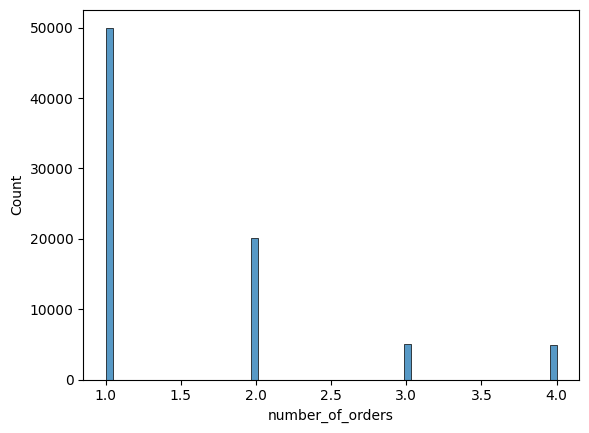

In [47]:
sns.histplot(data = clients_info, x = 'number_of_orders')

###Number_of_orders VS (Recency, average_ticket, age)

In [67]:
clients_info.query('number_of_orders == 1')[['recency', 'average_ticket', 'age']].describe()

,recency,average_ticket,age
count,50003.000000,50003.000000,50003.0
mean,575.071916,87.044720,41.078995
std,521.668045,95.407779,16.979938
min,0.000000,1.500000,12.0
25%,144.000000,29.760000,26.0
50%,422.000000,55.520000,41.0
75%,884.000000,110.000000,56.0
max,2364.000000,1884.940002,70.0


In [68]:
clients_info.query('number_of_orders == 2')[['recency', 'average_ticket', 'age']].describe()

,recency,average_ticket,age
count,20051.000000,20051.000000,20051.0
mean,387.806045,86.343540,41.078201
std,393.719990,65.879746,16.993825
min,0.000000,5.005000,12.0
25%,83.000000,41.500000,26.0
50%,256.000000,68.799999,41.0
75%,576.000000,111.015001,56.0
max,2326.000000,710.520002,70.0


In [69]:
clients_info.query('number_of_orders == 3')[['recency', 'average_ticket', 'age']].describe()

,recency,average_ticket,age
count,5026.000000,5026.000000,5026.0
mean,286.712296,85.840748,41.169717
std,311.154997,55.231861,16.90186
min,0.000000,10.130000,12.0
25%,58.000000,48.647501,27.0
50%,179.000000,72.493334,41.0
75%,411.000000,108.257501,56.0
max,2073.000000,515.650000,70.0


In [70]:
clients_info.query('number_of_orders == 4')[['recency', 'average_ticket', 'age']].describe()

,recency,average_ticket,age
count,4959.000000,4959.000000,4959.0
mean,229.375277,86.415961,41.203468
std,257.371729,46.455825,17.046514
min,0.000000,15.932500,12.0
25%,46.000000,53.670000,26.0
50%,143.000000,76.497500,42.0
75%,316.000000,108.396250,56.0
max,1910.000000,429.550000,70.0


#### There were no significant patterns envolving to track

<Axes: >

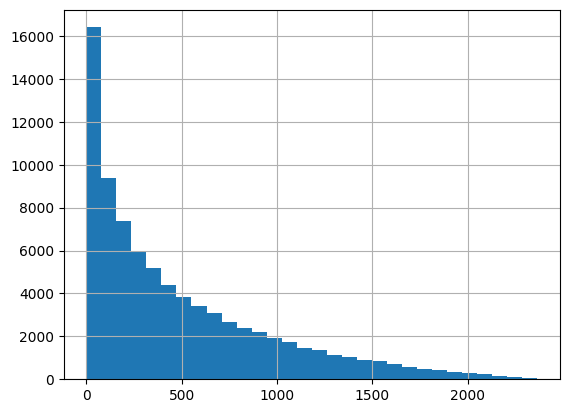

In [78]:
clients_info['recency'].hist(bins=30)


### Number_of_orders vs Gender

In [73]:
clients_info.query('gender == "F" & number_of_orders == 1')

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,is_loyal,is_churn
0,1,1,2025-05-13,2025-05-13,49,16.350000,16.350000,F,49,False,False
2,3,1,2023-03-20,2023-03-20,834,3.400000,3.400000,F,13,False,True
3,4,1,2023-09-22,2023-09-22,648,41.750000,41.750000,F,68,False,True
5,6,1,2022-08-02,2022-08-02,1064,25.990000,25.990000,F,26,False,True
10,12,1,2024-07-29,2024-07-29,337,54.940001,54.940001,F,62,False,True
...,...,...,...,...,...,...,...,...,...,...,...
80026,99986,1,2025-03-15,2025-03-15,108,74.000000,74.000000,F,29,False,True
80028,99988,1,2024-09-20,2024-09-20,284,36.000000,36.000000,F,26,False,True
80029,99989,1,2025-05-19,2025-05-19,43,154.000000,154.000000,F,35,False,False
80035,99997,1,2024-04-01,2024-04-01,456,181.000000,181.000000,F,13,False,True


In [75]:
pd.crosstab(clients_info.number_of_orders, clients_info.gender)

gender,F,M
number_of_orders,,
1,24902,25101
2,10069,9982
3,2556,2470
4,2472,2487


#### There were no significant patterns envolving to track

## **5. Kaplan-Meier Survival Analysis**

The Kaplan-Meier estimator is a non-parametric statistic used to estimate the probability that an event (in this case, **customer churn**) has **not** occurred by a certain time.

In the context of this project, it helps us understand **how long customers typically remain active** after their first purchase. It accounts for both:
- **Churned customers** (who stopped buying), and
- **Censored customers** (those still active at the time of analysis)

This method is especially useful when some clients haven’t yet churned — allowing us to model incomplete customer lifetimes accurately.


In [91]:
from lifelines import KaplanMeierFitter

### ⏳ Defining Duration for Survival Analysis

To generate the Kaplan-Meier survival curve, we need a `duration` column that represents how long each client remained active. This value varies depending on whether the client has churned or is still active:

- For **churned clients** (those whose last purchase was more than 90 days ago), `duration` is calculated as the number of days between their **first and last purchase**.
- For **active clients** (those who purchased within the last 90 days), `duration` is calculated as the number of days between their **first purchase and today** — since we don’t know when they will churn (this is known as **right-censoring** in survival analysis).

This logic allows us to properly model each customer's lifetime, whether they have already churned or not.


In [104]:
today = pd.to_datetime("today").normalize()

# Ajusta a coluna de duração corretamente
clients_info['duration'] = np.where(
    clients_info['recency'] > 90,  # churnou
    (clients_info['last_order_date'] - clients_info['first_order_date']).dt.days,
    (today - clients_info['first_order_date']).dt.days  # cliente ativo (censurado)
)

In [95]:
clients_info

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,lifelong_time,event
0,1,1,2025-05-13,2025-05-13,49,16.350000,16.350000,F,49,0 days,0
1,2,1,2025-04-13,2025-04-13,79,108.990000,108.990000,M,23,0 days,0
2,3,1,2023-03-20,2023-03-20,834,3.400000,3.400000,F,13,0 days,1
3,4,1,2023-09-22,2023-09-22,648,41.750000,41.750000,F,68,0 days,1
4,5,2,2023-11-03,2025-01-01,181,135.000000,67.500000,F,31,425 days,1
...,...,...,...,...,...,...,...,...,...,...,...
80034,99996,2,2022-06-13,2024-12-03,210,404.920002,202.460001,F,26,904 days,1
80035,99997,1,2024-04-01,2024-04-01,456,181.000000,181.000000,F,13,0 days,1
80036,99998,1,2021-07-26,2021-07-26,1436,77.290001,77.290001,M,56,0 days,1
80037,99999,1,2020-08-02,2020-08-02,1794,39.000000,39.000000,F,30,0 days,1


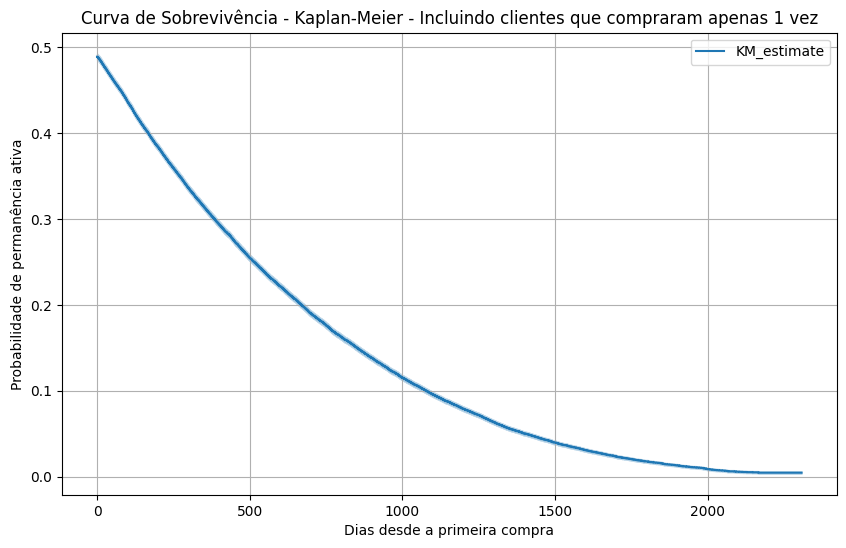

In [111]:
# Inicializa o modelo de Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajusta o modelo com os dados
kmf.fit(durations=clients_info['duration'], event_observed=clients_info['event'])

# Plota a curva de sobrevivência
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Curva de Sobrevivência - Kaplan-Meier - Incluindo clientes que compraram apenas 1 vez')
plt.xlabel('Dias desde a primeira compra')
plt.ylabel('Probabilidade de permanência ativa')
plt.grid(True)
plt.show()

## 🔍 Quick Insight from the Initial Survival Curve

After plotting the initial Kaplan-Meier survival curve for all customers, we observed that the survival probability starts around **0.5**. This suggests that **approximately 50% of customers never return after their first purchase**, indicating a significant early churn rate.

To better understand long-term customer behavior, we decided to create a second survival curve — this time **only for customers who made at least two purchases** — in order to analyze how the retention dynamics differ among more engaged clients.


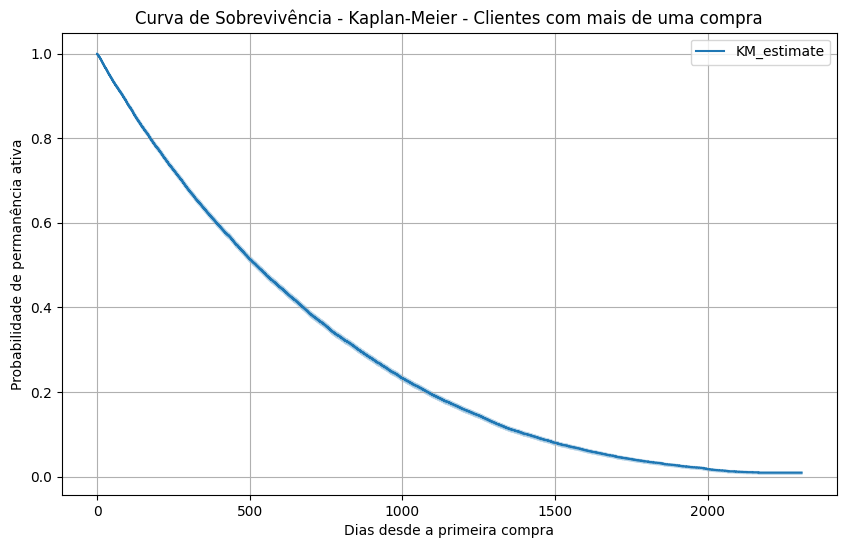

In [110]:
# Inicializa o modelo de Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajusta o modelo com os dados
kmf.fit(durations=clients_info.query('number_of_orders > 1')['duration'], event_observed=clients_info.query('number_of_orders > 1')['event'])

# Plota a curva de sobrevivência
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Curva de Sobrevivência - Kaplan-Meier - Clientes com mais de uma compra')
plt.xlabel('Dias desde a primeira compra')
plt.ylabel('Probabilidade de permanência ativa')
plt.grid(True)
plt.show()

## 📈 **Survival Curve Analysis – Clients With and Without Repeat Purchases**

---

### 🧪 Key Results

| Customer Group            | Initial Survival | Survival after ~500 days |
|---------------------------|------------------|---------------------------|
| **All clients**           | ~0.50            | ~0.25                     |
| **Clients with >1 order** | 1.00             | ~0.50                     |

---

### 🧠 Insights

#### 📌 1. 50% of clients churn after their first purchase
- The full-customer curve starts at ~0.5 → **half of the clients never buy again**.
- Possible reasons: poor onboarding, unmet expectations, no follow-up.

#### 📌 2. Repeat buyers stay much longer
- The survival curve for return clients only drops to ~0.5 after 500 days.
- Suggests strong product value after the second purchase.

---

### 🔍 Strategic Takeaways

| Behavior                    | Insight                              | Suggested Action                                  |
|----------------------------|--------------------------------------|---------------------------------------------------|
| High churn after 1st order | Weak onboarding or early experience  | Improve onboarding, follow-up emails, incentives |
| Loyal clients retain well  | Strong long-term value perception    | Loyalty programs, trigger engagement post-2nd buy|
| Retention stabilizes later | Key is converting 1st to 2nd purchase| Focus efforts on second purchase activation       |

---

### ✅ Next Steps

1. **Analyze time between 1st and 2nd orders**  
   → Find the ideal re-engagement window

2. **Build early churn prediction model**  
   → Identify those at risk right after first purchase

3. **Focus on second-purchase activation**  
   → This is the turning point in client lifetime

   Potential strategies:
   - Personalized coupons after 1st order
   - Email product recommendations
   - Automated reminders with relevant offers

---

### 📌 Final Summary

The survival analysis revealed a key insight:  
**The challenge isn’t retaining active customers — it’s turning first-time buyers into repeat ones.**  
Targeting customers after their first order can significantly boost retention and revenue.


## 📉 **Evaluating the 90-Day Churn Criterion Using Survival Analysis**


### 🎯 Core Question  
Does it make sense to define churn as **no purchases in the last 90 days**?

---

### 🧪 Kaplan-Meier Curve Evidence

- **~50% of clients** never make a second purchase (early churn)  
- Among return buyers, **50% stay active for ~500 days**  
- The curve **declines slowly**, showing that many clients have **long repurchase cycles**

---

### ⚠️ Interpreting the 90-Day Threshold

| Aspect                        | Observation                                                       |
|------------------------------|--------------------------------------------------------------------|
| **90-day cutoff**            | May be **too aggressive** in this context                         |
| **Still-active clients**     | Survival remains **high beyond 200+ days**                        |
| **Loyal client lifetime**    | Often exceeds **500 days** with reasonable survival probability   |

---

### ✅ Conclusion

**Using a fixed 90-day threshold may not reflect real customer behavior.**  
Survival analysis shows that **many clients repurchase after long gaps**, especially loyal ones.

---

### 🧠 Alternative Churn Strategies

| Strategy                              | Description |
|---------------------------------------|-------------|
| 🔄 **Percentile-based cutoff**        | Use survival percentiles (e.g., churn when 25% or 50% have dropped off) |
| 📈 **Estimated survival probability** | Define churn when survival probability falls below a threshold (e.g., 50%) |
| ⏳ **Continuous time modeling**       | Use models like **Cox Regression** or **Random Survival Forests** to predict **time to churn** instead of using a static cutoff |

---

### ✅ Recommended Next Steps

1. Use the Kaplan-Meier curve to find a more realistic churn point (e.g., when survival < 75% or < 50%)  
2. Build a **survival model** to estimate time-to-churn, accounting for censored data  
3. Identify clients with **recency > 90 days but high likelihood of return**, and target them with reactivation campaigns

---

### 📌 Final Note

A fixed 90-day churn rule may **overestimate churn**.  
Survival analysis reveals that many customers have **longer, less frequent purchase cycles**.  
Thus, **time-aware or survival-based models** offer a more accurate and behavior-driven approach to churn prediction.